Install Everything you need with !pip

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install tensorflow
!pip install tensorflow_probability
!pip install keras
!pip install scipy
!pip install pymc3

# Coin Flip Example. Bayesian thinking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## normal and beta distribution

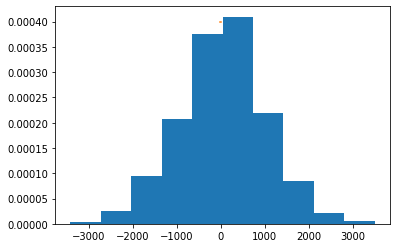

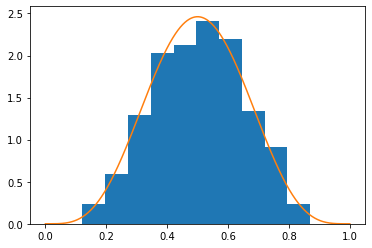

In [ ]:
samples = stats.norm.rvs(0, 1000, size=1000)

plt.hist(samples, density=True)

x = np.linspace(-5, 5, 1000)
y = stats.norm(0, 1000).pdf(x)
plt.plot(x, y)

plt.figure()

a, b = 5, 5
samples = stats.beta.rvs(a, b, size=1000)

plt.hist(samples, density=True)

x = np.linspace(0, 1, 1000)
y = stats.beta(a, b).pdf(x)
plt.plot(x, y)

## Let's flip coin and draw our belief about probability of observing heads.

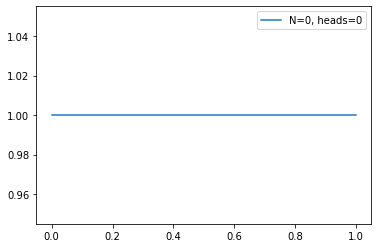

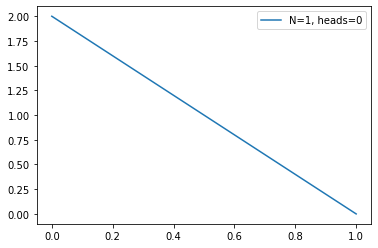

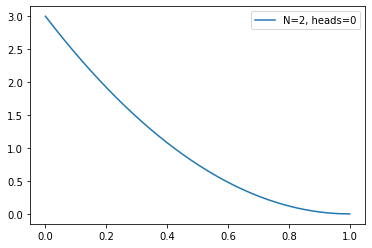

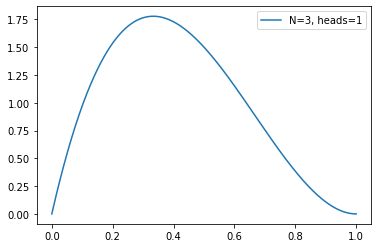

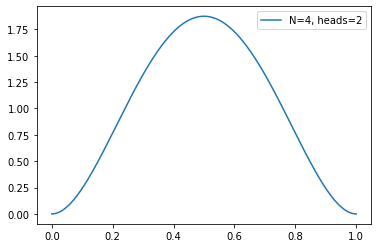

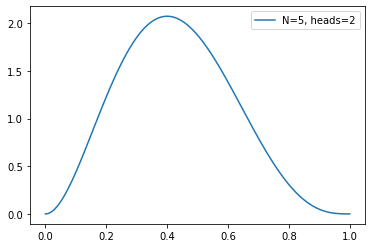

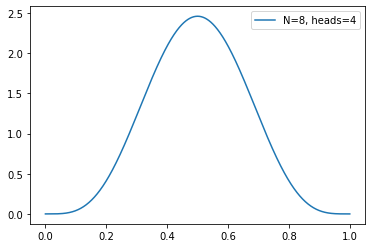

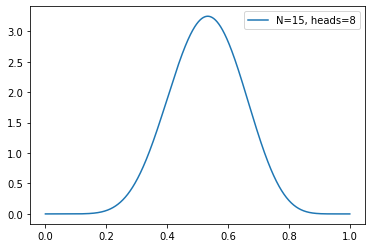

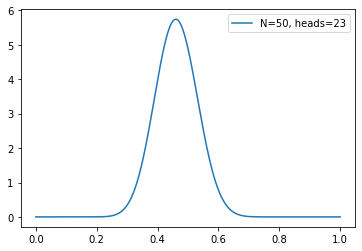

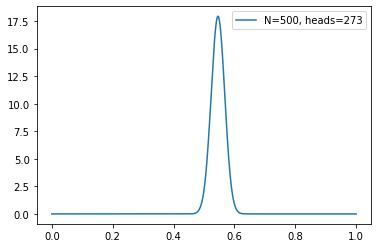

<Figure size 432x288 with 0 Axes>

In [ ]:
dist = stats.beta

p_success = 0.5
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]

data = stats.bernoulli.rvs(p_success, size = 500)

x = np.linspace(0, 1, 1000)

for i, N in enumerate(n_trials):
  heads = data[:N].sum()
  y = dist.pdf(x, 1 + heads, 1 + N - heads)
  plt.plot(x, y, label=f'N={N}, heads={heads}')
  plt.legend()
  plt.figure()

# Bayes theorem: *P(A|X) = P(X|A).P(A)* 
# new_beta = bernoulli * beta

# Our First Probabilistic Program (Space Shuttle Disaster)

In [ ]:
!wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv

--2021-08-24 19:54:01--  https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 413 [text/plain]
Saving to: ‘challenger_data.csv.1’

challenger_data.csv 100%[===================>]     413  --.-KB/s    in 0s      

2021-08-24 19:54:01 (17.8 MB/s) - ‘challenger_data.csv.1’ saved [413/413]



## Reading Data

In [ ]:
import pandas as pd
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


## Preprocessing Data (cleaning)

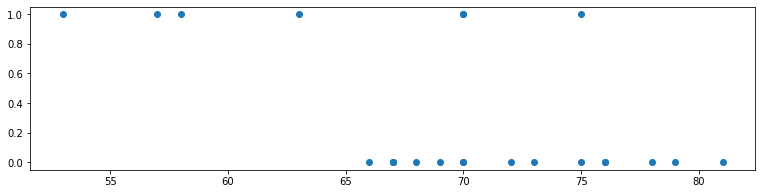

In [ ]:
accident_temperature = 31
data = raw_data.dropna().iloc[:-1, :]
data['Damage Incident'] = pd.to_numeric(data['Damage Incident']).astype(np.int64)
plt.figure(figsize=(13, 3))
plt.scatter(data['Temperature'], data['Damage Incident'])

## Define a function that sperate categories:

Logistic:

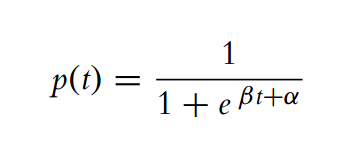



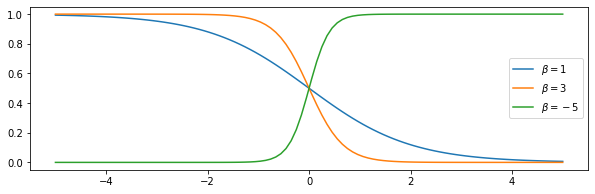

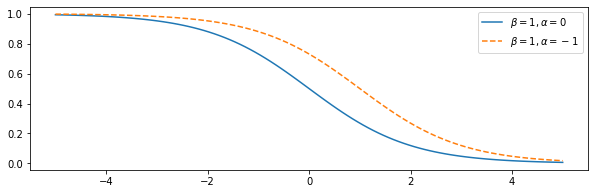

In [ ]:
plt.figure(figsize=(10, 3))
def logistic(t, beta):
    return 1.0 / (1.0 + np.exp(beta * t))

t = np.linspace(-5, 5, 100)
plt.plot(t, logistic(t, 1), label=r"$\beta = 1$")
plt.plot(t, logistic(t, 3), label=r"$\beta = 3$")
plt.plot(t, logistic(t, -5), label=r"$\beta = -5$")

plt.legend()

def logistic(t, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, t) + alpha))

plt.figure(figsize=(10, 3))
plt.plot(t, logistic(t, 1, 0), label=r"$\beta = 1, \alpha = 0$")
plt.plot(t, logistic(t, 1, -1), label=r"$\beta = 1, \alpha = -1$", ls='--')
plt.legend()

## Probabilistic Model Representation

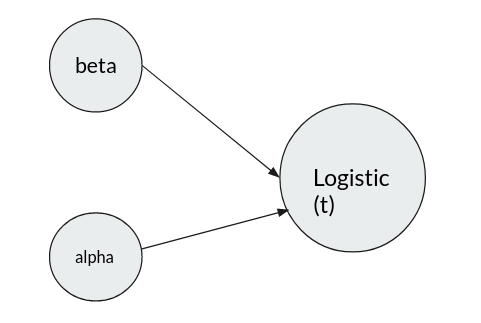

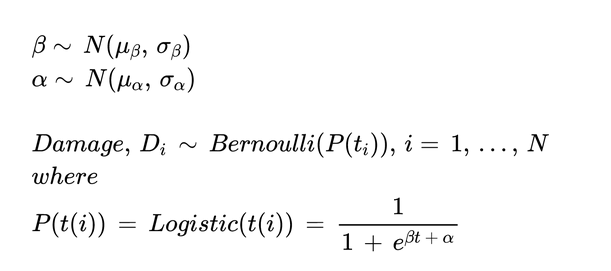

Posterior Probability using MCMC method.

In [ ]:
import pymc3 as pm

temperature = data['Temperature'].values
labels = data['Damage Incident'].values

# probabilistic model
with pm.Model() as model:

  beta = pm.Normal('beta', mu=0, tau=0.001, testval=0)
  alpha = pm.Normal('alpha', mu=0, tau=0.001, testval=0)

  p = 1.0 / (1.0 + np.exp(beta * temperature + alpha))

# inference 
with model:
  observed = pm.Bernoulli('bernoulli_obs', p, observed=labels)

  start = pm.find_MAP()
  step = pm.Metropolis()
  samples = pm.sample(120000, step=step, start=start)
  true_samples = samples[100000::2]





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 2 chains for 1_000 tune and 120_000 draw iterations (2_000 + 240_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## Posterior Distribution of parameters
Parameter uncertainty because of:

  1- overlap of defects-to-nondefects
  
  2- low sample size

(array([0.00140635, 0.01476665, 0.04444059, 0.07485285, 0.04895848,
        0.0525974 , 0.06652024, 0.03097481, 0.0133603 , 0.00370924]),
 array([-28.83902916, -25.99478227, -23.15053538, -20.30628848,
        -17.46204159, -14.6177947 , -11.77354781,  -8.92930091,
         -6.08505402,  -3.24080713,  -0.39656024]),
 <a list of 10 Patch objects>)

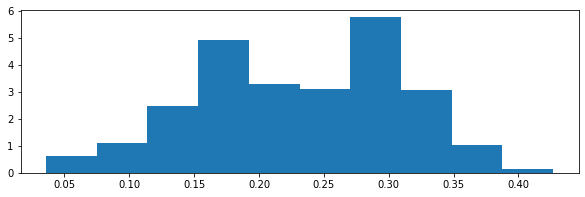

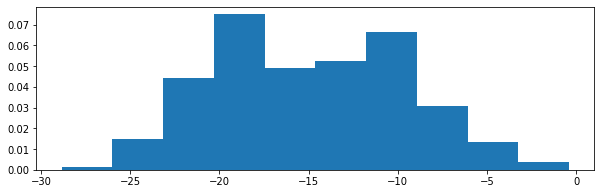

In [ ]:
alpha_samples = true_samples['alpha']
beta_samples = true_samples['beta']

plt.figure(figsize=(10, 3))
plt.hist(beta_samples, label='posterior of beta', density=True)

plt.figure(figsize=(10, 3))
plt.hist(alpha_samples, label='posterior of alpha', density=True)

## Expected Probability for each temperature

(20000, 1) (1, 50)
(20000, 50)
(50,)


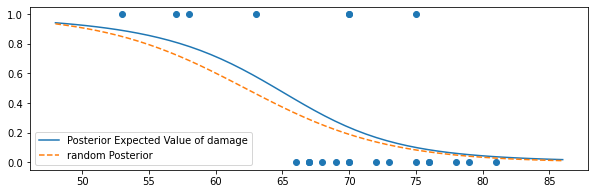

In [ ]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50).reshape(1, -1)
p_t = logistic(t, beta_samples.reshape(-1, 1), alpha_samples.reshape(-1, 1))

print(beta_samples.reshape(-1, 1).shape, t.shape) # np.dot(beta, t)
print(p_t.shape)
mean_prob_t = p_t.mean(axis=0)
print(mean_prob_t.shape)

plt.figure(figsize=(10, 3))
plt.plot(t[0], mean_prob_t, label='Posterior Expected Value of damage')
plt.scatter(data['Temperature'], data['Damage Incident'])
plt.plot(t[0], p_t[604, :], label='random Posterior', ls='--')
plt.legend()

## Probability Distribution for each temperature

How uncertain are we in different temperatures?

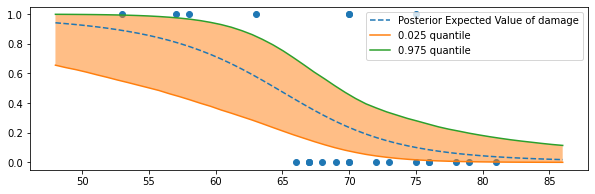

In [ ]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(10, 3))
plt.plot(t[0], mean_prob_t, label='Posterior Expected Value of damage', ls='--')
plt.scatter(data['Temperature'], data['Damage Incident'])

quantiles = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.plot(t[0], quantiles[0], label='0.025 quantile')
plt.plot(t[0], quantiles[1], label='0.975 quantile')
plt.fill_between(t[0], *quantiles, alpha=0.5)
plt.legend()

## what happended at the day of Challenger Disaster?

(array([7.22679334e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

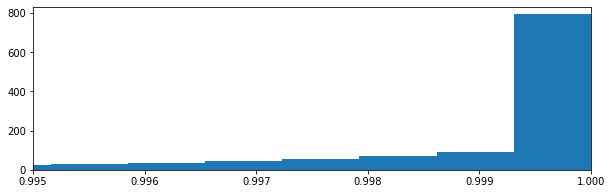

In [ ]:
prob_31 = logistic(31, beta_samples, alpha_samples)
plt.figure(figsize=(10, 3))
plt.xlim(0.995, 1)
plt.hist(prob_31, density=True, bins=1000)

# Probabilistic Regression (Posterior Probability using variational inference methods)

y: (150,), x: (150, 1), x_test: (150, 1)


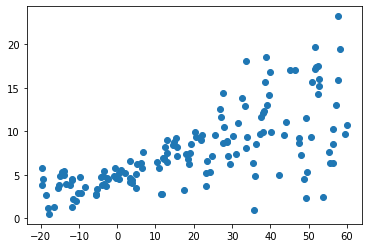

In [ ]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_test = load_dataset()

plt.scatter(x, y)
print(f'y: {y.shape}, x: {x.shape}, x_test: {x_test.shape}')

# Simple Linear Regression

y_hats: (150, 1)


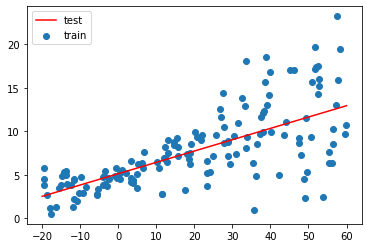

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda y_true, y_hat: tf.reduce_mean(tf.square(y_true - y_hat)))

model.fit(x, y, epochs=500, verbose=False)

y_hats = model(x_test)

print(f'y_hats: {y_hats.shape}')

plt.scatter(x, y, label='train')
plt.plot(x_test, y_hats, label='test', c='r')
plt.legend()

# Linear Regression with Normal output distribution

y_hats: (150, 1)


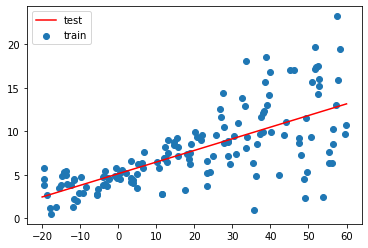

In [ ]:
import tensorflow_probability as tfp

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(
      lambda mean: tfp.distributions.Normal(loc=mean, scale=1))
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda y_true, y_dist: -y_dist.log_prob(y_true))


model.fit(x, y, epochs=500, verbose=False)

y_hats = model(x_test)


print(f'y_hats: {y_hats.shape}')

plt.scatter(x, y, label='train')
plt.plot(x_test, y_hats.mean(), label='test', c='r')
plt.legend()

# Learn Variability

y_hats: (1, 150, 1)


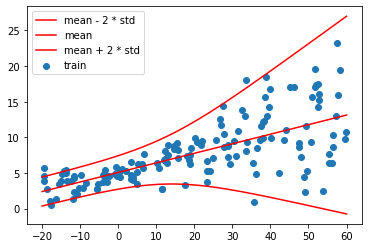

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                         scale=1 + tf.math.softplus(t[..., 1:])),
      convert_to_tensor_fn=lambda s: s.sample(1)
      )
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05),
              loss=lambda y_true, y_dist: -y_dist.log_prob(y_true))

model.fit(x, y, epochs=500, verbose=False)

y_hats = model(x_test)

mean = y_hats.mean()
std = y_hats.stddev()

print(f'y_hats: {y_hats.shape}')

plt.scatter(x, y, label='train')
plt.plot(x_test, mean - 2 * std, label='mean - 2 * std', c='r')
plt.plot(x_test, mean, label='mean', c='r')
plt.plot(x_test, mean + 2 * std, label='mean + 2 * std', c='r')

plt.legend()

# Learn Parameter Variability
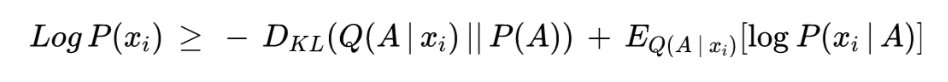

n 2
2


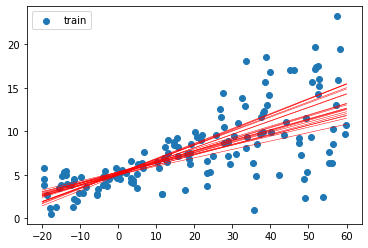

In [ ]:
def Q(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
          tfp.distributions.Normal(loc=t[..., :n],
                     scale=0.001 + tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def P(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
          tfp.distributions.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, Q, P, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
        lambda mean: tfp.distributions.Normal(loc=mean, scale=1)
        )
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda y_true, y_dist: -y_dist.log_prob(y_true))

model.fit(x, y, epochs=1000, verbose=False)

y_hats_samples = [model(x_test) for i in range(20)]

plt.scatter(x, y, label='train')

for i, y_hats in enumerate(y_hats_samples): 
  plt.plot(x_test, y_hats.mean(), c='r', linewidth=0.5)

plt.legend()

# Normalizing Flow